# Kratos example: linear model

In [1]:
from probabilistic_library import ReliabilityProject, ReliabilityMethod, DistributionType, CombineProject, CombineType, CombinerMethod, CompareType
from probabilistic_library import UncertaintyProject, UncertaintyMethod, Stochast

### Model

In [2]:
from run_kratos_quay_wall import zfuncwrapper_linear

### Variables

In [3]:
def define_project_variables(project):

    project.variables["geo_young_modulus"].is_array = True
    project.variables["geo_young_modulus"].array_size = 7
    for i in range(project.variables["geo_young_modulus"].array_size):
        if i in [0, 1, 2, 3]: # Clays with low-medium plasticity, medium
            young_modulus = Stochast()
            young_modulus.distribution = DistributionType.uniform
            young_modulus.minimum = 5*10**6
            young_modulus.maximum = 8*10**6
        elif i in [4, 5, 6]: # Sand, uniform, medium
            young_modulus = Stochast()
            young_modulus.distribution = DistributionType.uniform
            young_modulus.minimum = 30*10**6
            young_modulus.maximum = 50*10**6
        project.variables["geo_young_modulus"].array_variables.append(young_modulus)

    project.variables["interface_stiffness"].distribution = DistributionType.deterministic
    project.variables["interface_stiffness"].is_array = True
    project.variables["interface_stiffness"].array_size = 6
    project.variables["interface_stiffness"].mean = 10**11 # value checked

    project.variables["sheetpile_young_modulus"].distribution = DistributionType.deterministic
    project.variables["sheetpile_young_modulus"].is_array = True
    project.variables["sheetpile_young_modulus"].array_size = 1
    project.variables["sheetpile_young_modulus"].mean = 200e9 # value checked

    project.variables["sheetpile_poisson_ratio"].distribution = DistributionType.deterministic
    project.variables["sheetpile_poisson_ratio"].is_array = True
    project.variables["sheetpile_poisson_ratio"].array_size = 1
    project.variables["sheetpile_poisson_ratio"].mean = 0.0 # value checked

    project.variables["sheetpile_thickness"].distribution = DistributionType.deterministic
    project.variables["sheetpile_thickness"].is_array = True
    project.variables["sheetpile_thickness"].array_size = 1
    project.variables["sheetpile_thickness"].mean = 0.02159 # value checked

    return project

### Uncertainty analysis (total displacement)

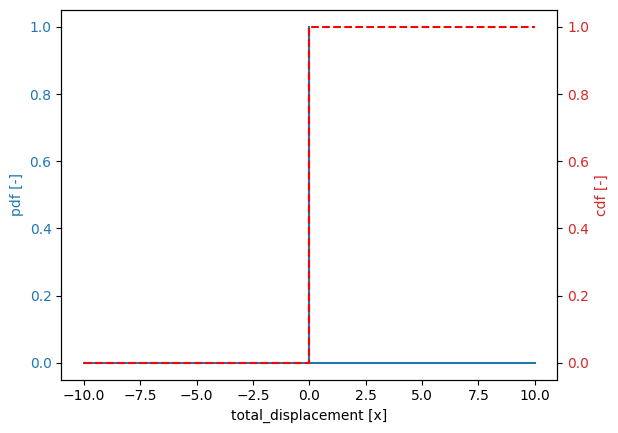

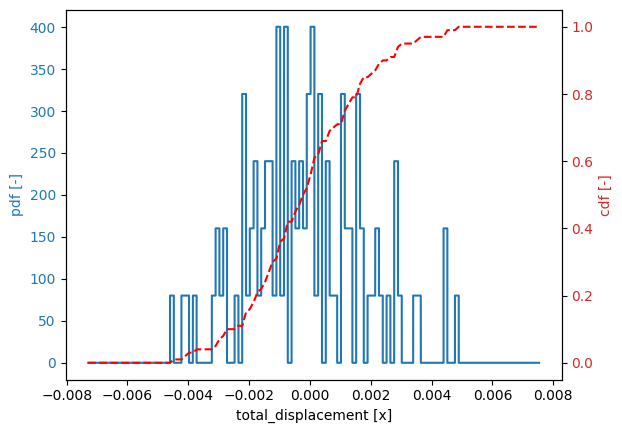

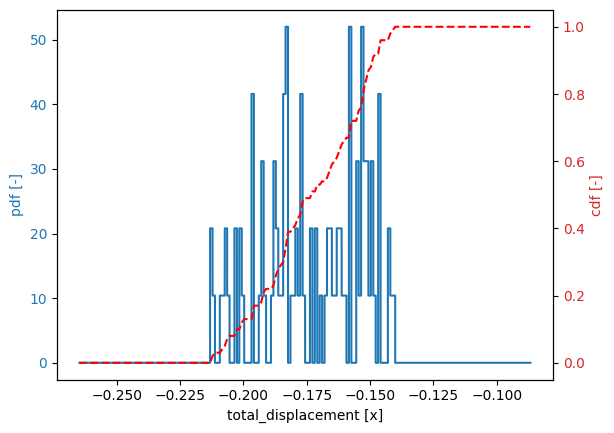

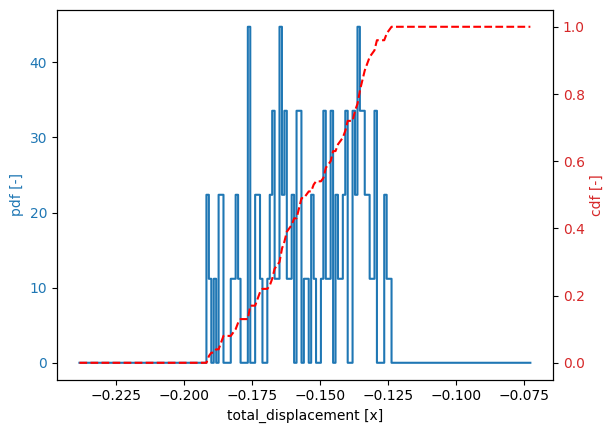

In [4]:
output_stage = [0, 1, 2, 3]

for val in output_stage:

    project = UncertaintyProject()
    wrapper = zfuncwrapper_linear(output_stage_number = val, clean_up = True)
    project.model = wrapper.total_displacement

    project = define_project_variables(project)

    project.settings.uncertainty_method = UncertaintyMethod.crude_monte_carlo
    project.settings.variation_coefficient = 0.02
    project.settings.minimum_samples = 50
    project.settings.maximum_samples = 100
    project.settings.save_convergence = True
    project.settings.save_realizations = True

    project.run()

    project.stochast.plot()

### Uncertainty analysis (max bending moment)

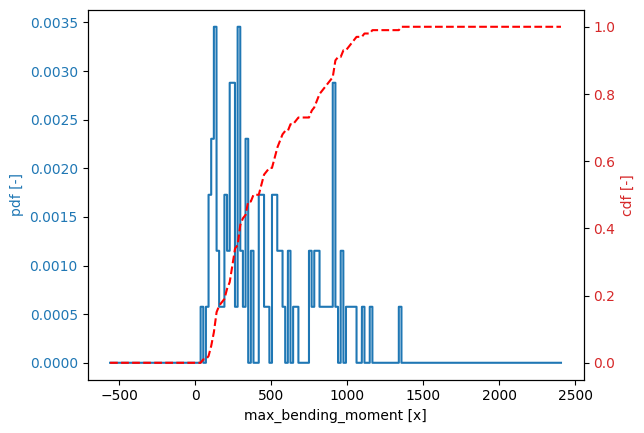

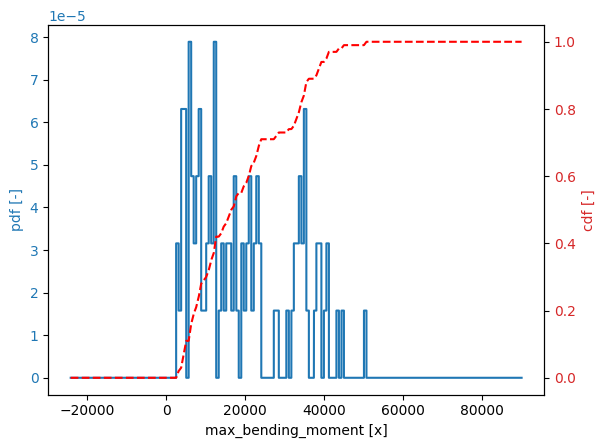

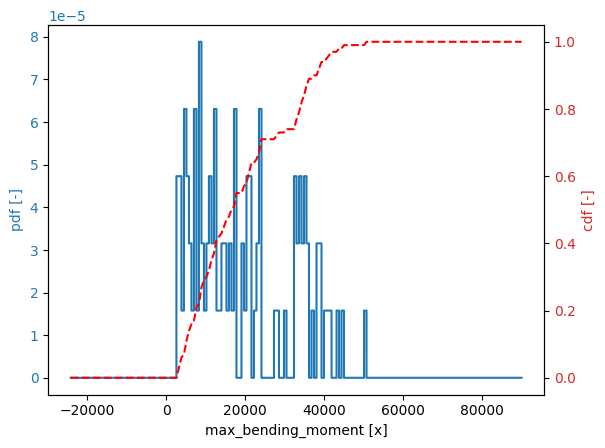

In [5]:
output_stage = [1, 2, 3] # 0 gives no results

for val in output_stage:

    project = UncertaintyProject()
    wrapper = zfuncwrapper_linear(output_stage_number = val, clean_up = True)
    project.model = wrapper.max_bending_moment

    project = define_project_variables(project)

    project.settings.uncertainty_method = UncertaintyMethod.crude_monte_carlo
    project.settings.variation_coefficient = 0.02
    project.settings.minimum_samples = 50
    project.settings.maximum_samples = 100
    project.settings.save_convergence = True
    project.settings.save_realizations = True

    project.run()

    project.stochast.plot()

### Reliability analysis (total displacement)

In [ ]:
project = ReliabilityProject()
wrapper = zfuncwrapper_linear(output_stage_number = 2, clean_up = True)
project.model = wrapper.total_displacement

project.model.print()

In [ ]:
project = define_project_variables(project)

project.settings.reliability_method = ReliabilityMethod.form
project.settings.variation_coefficient = 0.02
project.settings.maximum_iterations = 50
project.settings.save_convergence = True
project.settings.save_realizations = True

project.limit_state_function.compare_type = CompareType.greater_than
project.limit_state_function.parameter = project.model.output_parameters[0]
project.limit_state_function.critical_value = 0.35

project.run()

project.design_point.print()

dp1 = project.design_point

### Reliability analysis (max bending moment)

In [ ]:
wrapper = zfuncwrapper_linear(output_stage_number = 2, clean_up = True)
project.model = wrapper.max_bending_moment

project.model.print()

project.settings.reliability_method = ReliabilityMethod.crude_monte_carlo
project.settings.variation_coefficient = 0.02
project.settings.minimum_samples = 50
project.settings.maximum_samples = 100
project.settings.save_convergence = True
project.settings.save_realizations = True

project.limit_state_function.compare_type = CompareType.greater_than
project.limit_state_function.parameter = project.model.output_parameters[0]
project.limit_state_function.critical_value = 40000

project.run()

project.design_point.print()

dp2 = project.design_point

### Combine probabilities

In [ ]:
combine_project = CombineProject()

combine_project.design_points.append(dp1)
combine_project.design_points.append(dp2)

combine_project.settings.combine_type = CombineType.series
combine_project.settings.combiner_method = CombinerMethod.hohenbichler_form

combine_project.run()

combine_project.design_point.print()